# Sepsis Prediction

## Business Understanding

Sepsis is a condition in which the body's response to an existing infection becomes excessive, triggering a cascade of failures in various systems such as the lungs, urinary tract, skin, or gastrointestinal tract. Sepsis is a life-threatening condition that demands prompt medical intervention. Intensive Care Units (ICUs) bear the responsibility of closely monitoring patients for the development of sepsis.

Goal: Build a machine learning model that predicts whether a patient will develop sepsis.

### Hypothesis
Null: The occurrence of sepsis is not influenced by the patients' medical history features.

Alternate: The occurrence of sepsis is influenced by the patients' medical history features.

### Analytical Questions:
1. What is the distribution of sepsis cases in the dataset?
2. How do different features (e.g., PRG, PL, Age) correlate with the occurrence of sepsis?
3. Are there noticeable differences in the distribution of vital signs (e.g., TS, BD2) between patients with positive and negative sepsis status?
4. How does age impact the likelihood of sepsis?



## Data Understanding

In [2]:
# import necessary libraries
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt 
import seaborn as sns
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import joblib
#Evaluation
from sklearn import metrics
from sklearn.metrics import classification_report

#Libraries for feature scaling
from sklearn.preprocessing import StandardScaler, FunctionTransformer, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


#Libraries for Validation
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.utils.class_weight import compute_class_weight





## Load the train and test datasets

In [3]:
# Load the train data set
data = pd.read_csv(r".\archive 1\Paitients_Files_Train.csv")

data.head(10)

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,Negative
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,Positive
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,Negative
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,Positive
5,ICU200015,5,116,74,0,0,25.6,0.201,30,1,Negative
6,ICU200016,3,78,50,32,88,31.0,0.248,26,0,Positive
7,ICU200017,10,115,0,0,0,35.3,0.134,29,1,Negative
8,ICU200018,2,197,70,45,543,30.5,0.158,53,1,Positive
9,ICU200019,8,125,96,0,0,0.0,0.232,54,1,Positive


In [4]:
#load the test data set
data_2 = pd.read_csv(r".\archive 1\Paitients_Files_Test.csv")

data_2.head(10)

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
0,ICU200609,1,109,38,18,120,23.1,0.407,26,1
1,ICU200610,1,108,88,19,0,27.1,0.400,24,1
2,ICU200611,6,96,0,0,0,23.7,0.190,28,1
3,ICU200612,1,124,74,36,0,27.8,0.100,30,1
4,ICU200613,7,150,78,29,126,35.2,0.692,54,0
5,ICU200614,4,183,0,0,0,28.4,0.212,36,1
6,ICU200615,1,124,60,32,0,35.8,0.514,21,1
7,ICU200616,1,181,78,42,293,40.0,1.258,22,1
8,ICU200617,1,92,62,25,41,19.5,0.482,25,0
9,ICU200618,0,152,82,39,272,41.5,0.270,27,0


### Domain Knowledge
### ID: Unique number to represent patient ID
#### PRG: Plasma glucose
#### PL: Blood Work Result-1 (mμ U/ml)
#### PR: Blood Pressure (mm Hg)
#### SK: Blood Work Result-2 (mm)
#### TS: Blood Work Result-3 (mμ U/ml)
#### M11: Body mass index (weight in kg/(height in m)^2)
#### BD2: Blood Work Result-4 (mμ U/ml)
#### Age: Age of Patient(Years)
#### Insuarance: If a patient holds a valid health insuarance card?
#### Sepsis(Target Variable): Positive: if a patient in ICU will develop a sepsis , and Negative: otherwise

Reference: https://www.kaggle.com/code/anhhunhvn/detect-sepsis-with-patients-dataset
 
 
 

EDA

In [5]:
# get concise summary of the train DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         599 non-null    object 
 1   PRG        599 non-null    int64  
 2   PL         599 non-null    int64  
 3   PR         599 non-null    int64  
 4   SK         599 non-null    int64  
 5   TS         599 non-null    int64  
 6   M11        599 non-null    float64
 7   BD2        599 non-null    float64
 8   Age        599 non-null    int64  
 9   Insurance  599 non-null    int64  
 10  Sepssis    599 non-null    object 
dtypes: float64(2), int64(7), object(2)
memory usage: 51.6+ KB


In [6]:
# lets get the summary statistics
data.describe().T

,count,mean,std,min,25%,50%,75%,max
PRG,599.0,3.824708,3.362839,0.000,1.000,3.000,6.000,17.00
PL,599.0,120.153589,32.682364,0.000,99.000,116.000,140.000,198.00
PR,599.0,68.732888,19.335675,0.000,64.000,70.000,80.000,122.00
SK,599.0,20.562604,16.017622,0.000,0.000,23.000,32.000,99.00
TS,599.0,79.460768,116.576176,0.000,0.000,36.000,123.500,846.00
M11,599.0,31.920033,8.008227,0.000,27.100,32.000,36.550,67.10
BD2,599.0,0.481187,0.337552,0.078,0.248,0.383,0.647,2.42
Age,599.0,33.290484,11.828446,21.000,24.000,29.000,40.000,81.00
Insurance,599.0,0.686144,0.464447,0.000,0.000,1.000,1.000,1.00


In [7]:
# Check for null values in the train set
data.isnull().sum()

ID           0
PRG          0
PL           0
PR           0
SK           0
TS           0
M11          0
BD2          0
Age          0
Insurance    0
Sepssis      0
dtype: int64

In [8]:
# chek for null values in the test set
data_2.isnull().sum()

ID           0
PRG          0
PL           0
PR           0
SK           0
TS           0
M11          0
BD2          0
Age          0
Insurance    0
dtype: int64

In [9]:
#check for duplicates
data.duplicated().sum()

0

In [10]:
data_2.duplicated().sum()

0

In [11]:
data['Sepssis'].unique()

array(['Positive', 'Negative'], dtype=object)

## Univariate Analysis

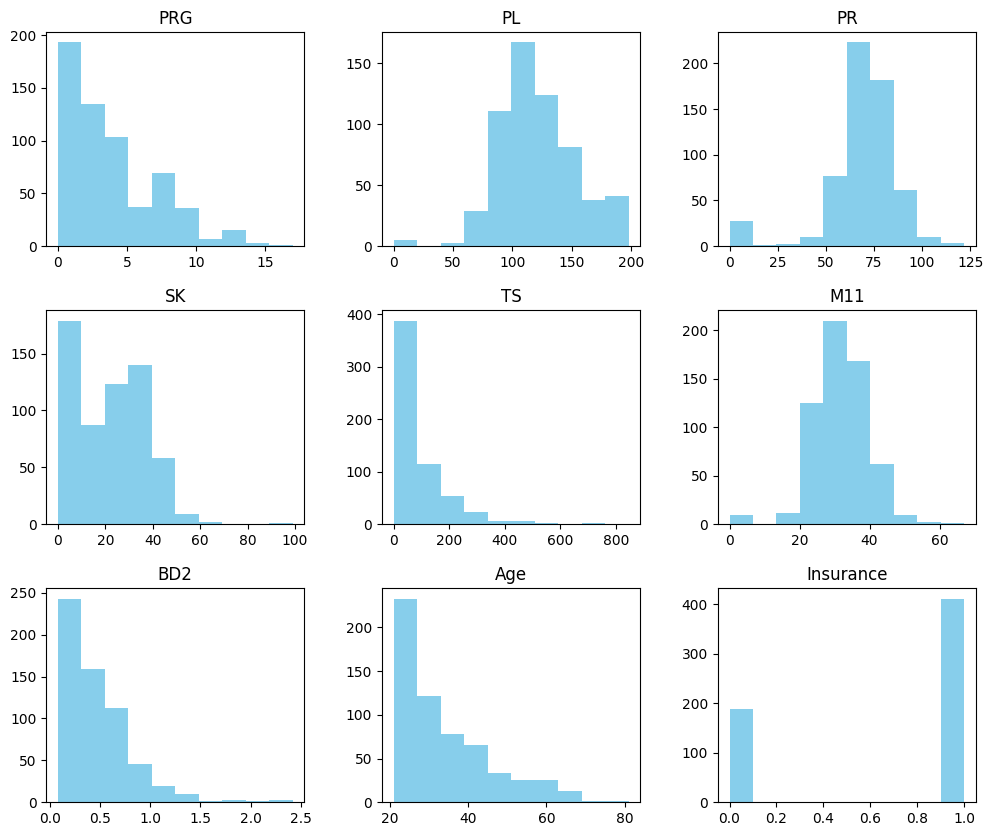

In [12]:
data.hist(figsize=(12, 10), grid=False, color='skyblue')
plt.show()

### Observation: 
From the histograms above, we can tell the skweness as follows:
Positively-skewed: TS, BD2, Age, PRG

Normally-distributed (approximately): PR, SK, PL, M11

### What is the distribution of sepsis cases in the dataset?

c:\Users\HomePC\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\HomePC\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\HomePC\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\HomePC\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

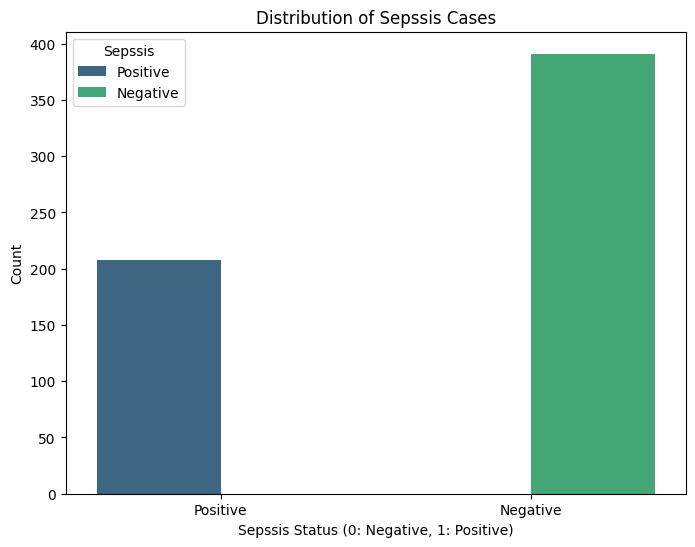

Sepssis
Negative    391
Positive    208
Name: count, dtype: int64


In [13]:
# Check the distribution of sepsis cases
sepsis_distribution = data['Sepssis'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Sepssis', data=data, palette='viridis', hue='Sepssis')
plt.title('Distribution of Sepssis Cases')
plt.xlabel('Sepssis Status (0: Negative, 1: Positive)')
plt.ylabel('Count')
plt.show()

# Display the counts
print(sepsis_distribution)


### How does age impact the likelihood of sepsis?

c:\Users\HomePC\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\HomePC\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\HomePC\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\HomePC\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

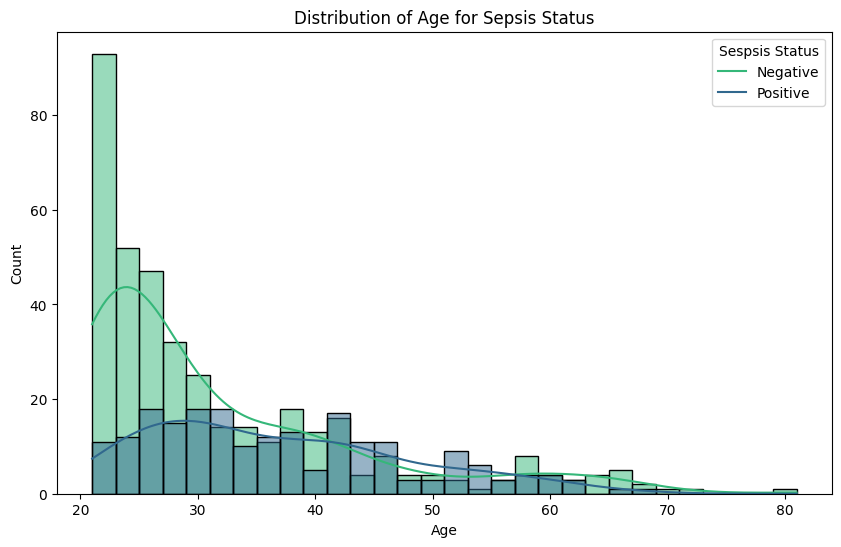

          count       mean        std   min   25%   50%    75%   max
Sepssis                                                             
Negative  391.0  31.478261  11.913531  21.0  23.0  27.0  37.00  81.0
Positive  208.0  36.697115  10.904929  21.0  28.0  35.0  43.25  67.0


In [14]:
# Plot histograms for age distribution
plt.figure(figsize=(10, 6))
sns.histplot(data, x='Age', hue='Sepssis', kde=True, palette='viridis', bins=30)
plt.title('Distribution of Age for Sepsis Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='Sespsis Status', labels=['Negative', 'Positive'])
plt.show()

# Calculate summary statistics
age_summary = data.groupby('Sepssis')['Age'].describe()
print(age_summary)


Is there a statistically significant difference in the distribution of various medical parameters (e.g., PRG, PL, PR, SK, TS, M11, BD2) between patients with positive sepsis status and those with negative sepsis status?

c:\Users\HomePC\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\HomePC\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\HomePC\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\HomePC\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

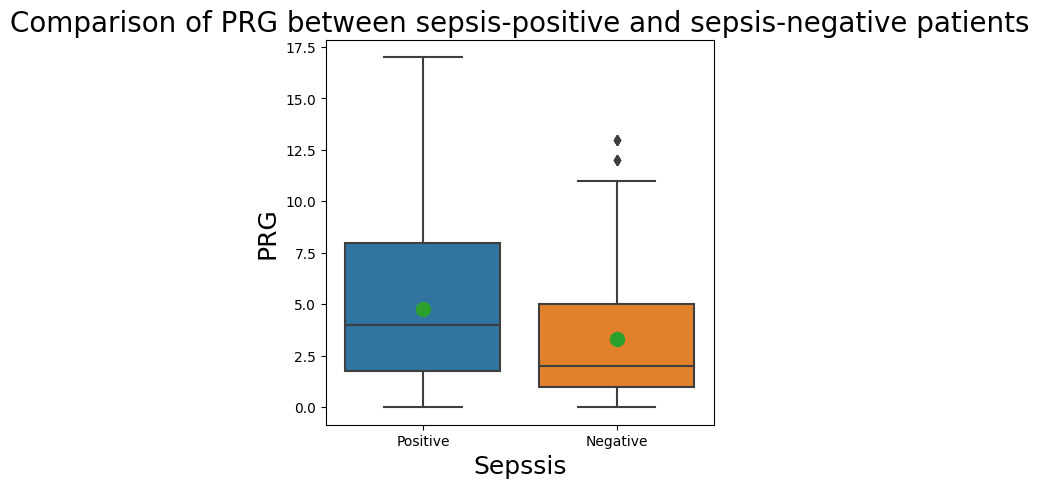

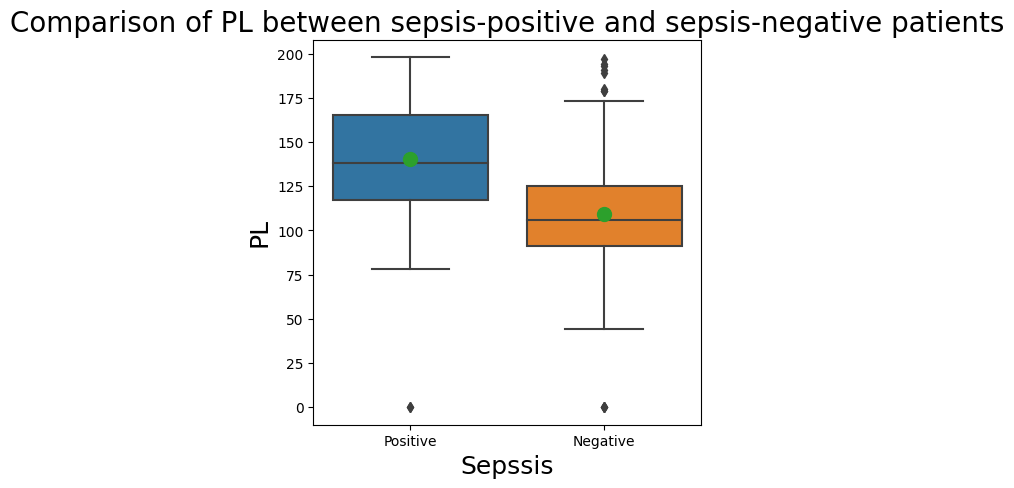

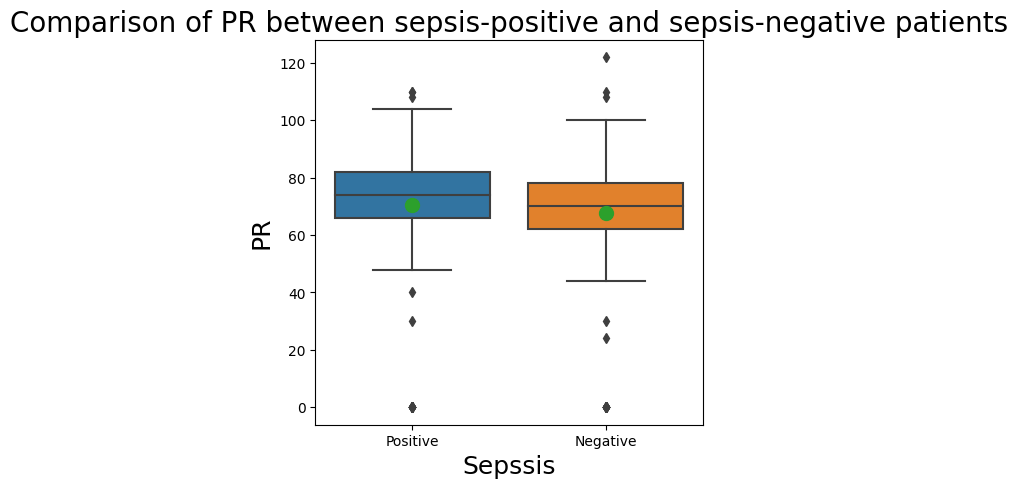

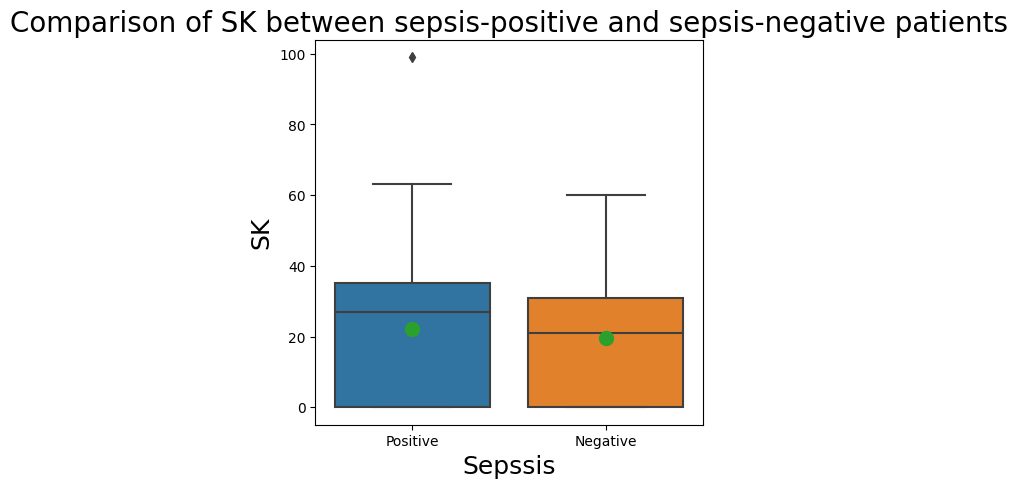

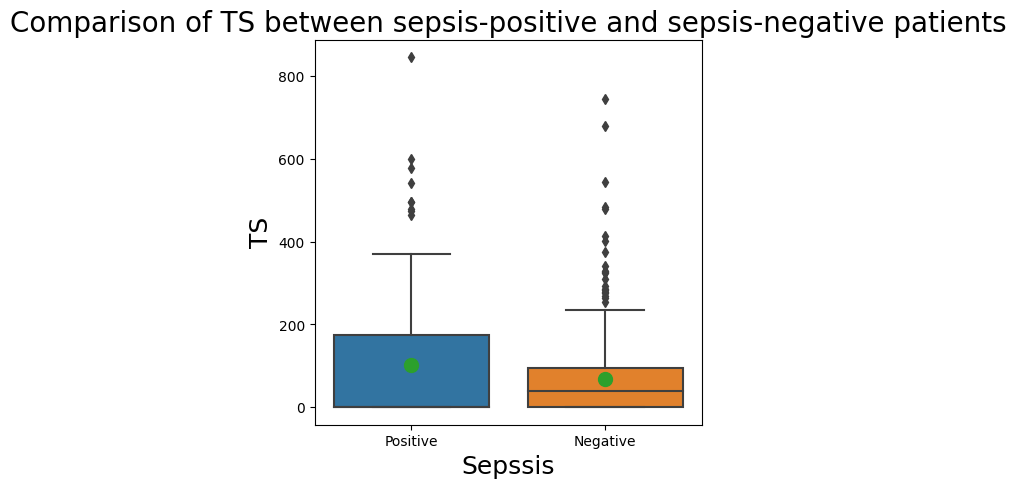

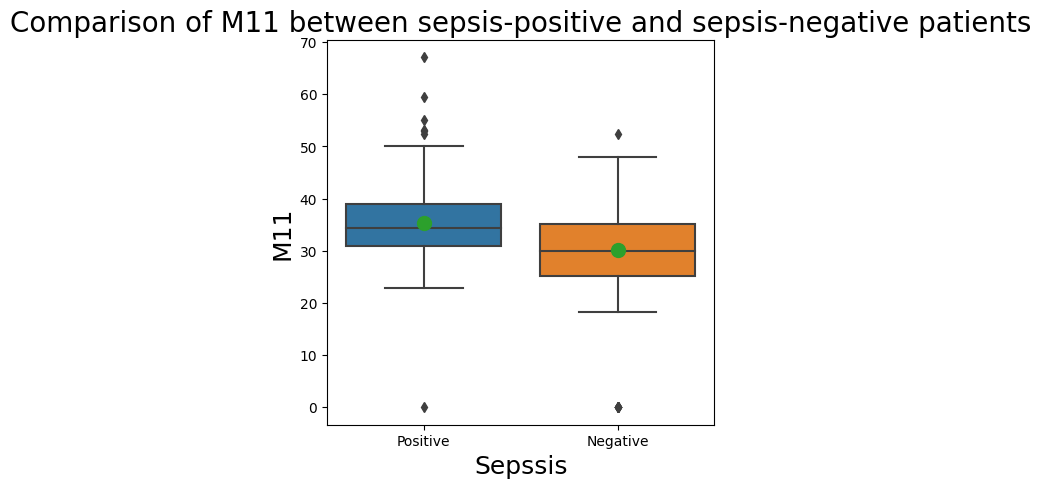

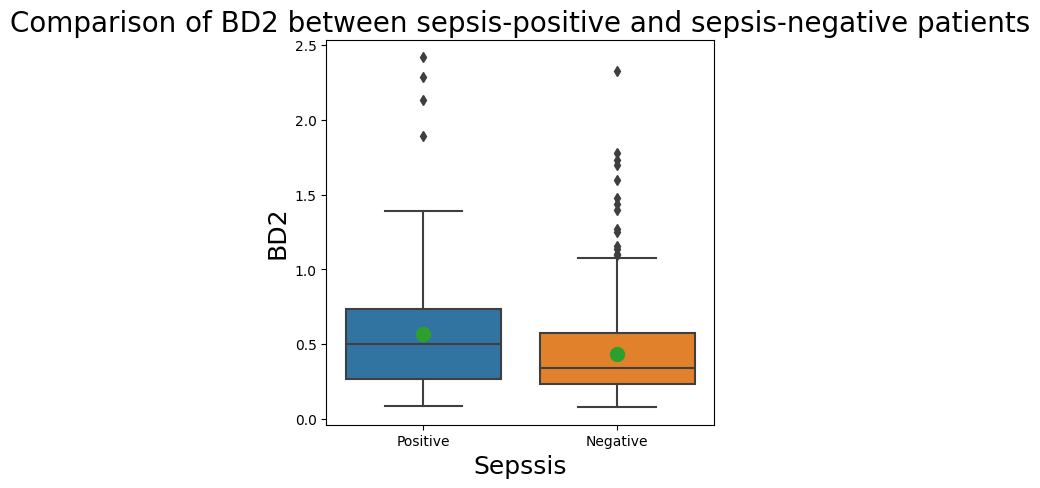

In [15]:
def plot_compare_sepsis(df, col):
    plt.figure(figsize=(5, 5))   
    plt.title('Comparison of ' + str(col) + ' between sepsis-positive and sepsis-negative patients', 
              fontsize=20)
    
    # Property for the mean marker
    meanline = {'marker':'o', 'markersize':'10'}
    
    # Box plot of each column separated by Positive and Negative with sepsis
    # Show mean on box plot
    sns.boxplot(data=df, x='Sepssis', y=col, showmeans=True, meanprops=meanline)
    
    plt.xlabel('Sepssis', size=18)
    plt.ylabel(col, size=18)

cols = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2']

for col in cols:
    plot_compare_sepsis(data, col)

### Observation
From the box plots illustrating the values of different health features among patients with and without sepsis above, it is evident that individuals testing positive for sepsis exhibit higher readings in all health features compared to the negative group. Therefore, a reasonable inference can be made that patients with elevated levels of plasma glucose, BMI, and the four blood work results are more prone to developing sepsis.

c:\Users\HomePC\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\HomePC\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\HomePC\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\HomePC\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

<Axes: >

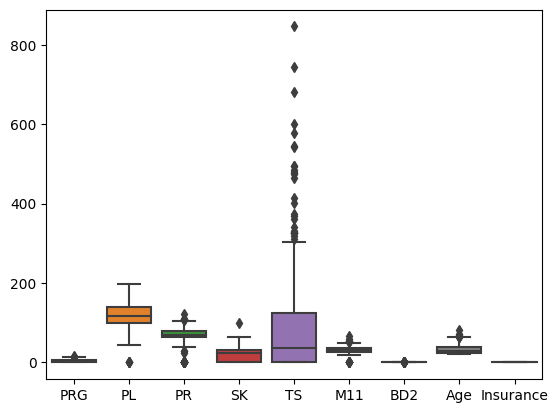

In [16]:
sns.boxplot(data=data)

### Observation

The training set contains several outliers, notably in the TS column, which will undergo further investigation.
To enhance clarity, columns with relatively small values in the current scale are plotted separately for a more detailed visualization.







c:\Users\HomePC\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: >

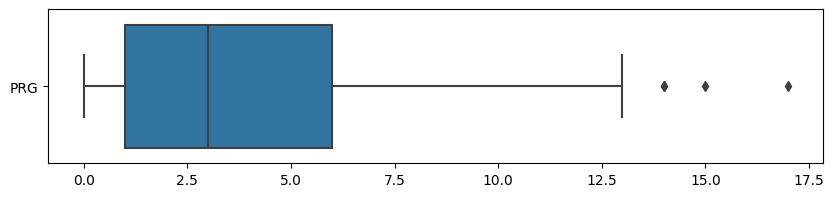

In [17]:
plt.figure(figsize=(10, 2))
sns.boxplot(data=data[['PRG']], orient='h')

c:\Users\HomePC\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: >

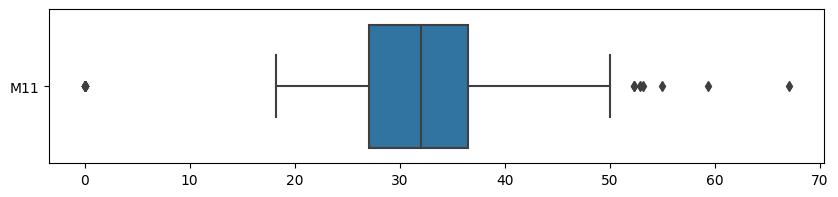

In [18]:
plt.figure(figsize=(10, 2))
sns.boxplot(data=data[['M11']], orient='h')


<Axes: >

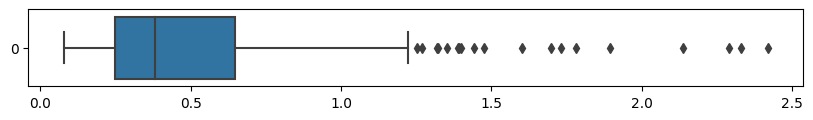

In [19]:
plt.figure(figsize=(10, 1))
sns.boxplot(data=data['BD2'], orient='h')

## Data Cleanining and Preprocessing

In order to protect patients' privacy, their ID and Insurance status will be dropped before feeding to train the model. Moreover, ID column can cause data leakage.
For this reason, we delete the two columns.

In [20]:
# Drop ID (both sets) and Insurance (test set) columns
data.drop(columns=['ID', 'Insurance'], axis='columns', inplace=True)
data_2.drop(columns=['Insurance'], axis='columns', inplace=True)

# Rename the misspelled Sepsis column
data.rename(columns={"Sepssis": "Sepsis"}, inplace=True)

In [21]:
# Encode the Sepsis column into binary
# check unique values
data['Sepsis'].unique()

array(['Positive', 'Negative'], dtype=object)

In [22]:
# Replace Positive with 1 and Negative with 0 in Sepsis column
encoder = LabelEncoder()
data['Sepsis'].replace(to_replace='Positive', value='1', inplace=True)
data['Sepsis'].replace(to_replace='Negative', value='0', inplace=True)

## change datatype to interger for training purpose
data['Sepsis'] = data['Sepsis'].astype('int')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PRG     599 non-null    int64  
 1   PL      599 non-null    int64  
 2   PR      599 non-null    int64  
 3   SK      599 non-null    int64  
 4   TS      599 non-null    int64  
 5   M11     599 non-null    float64
 6   BD2     599 non-null    float64
 7   Age     599 non-null    int64  
 8   Sepsis  599 non-null    int32  
dtypes: float64(2), int32(1), int64(6)
memory usage: 39.9 KB


<Axes: >

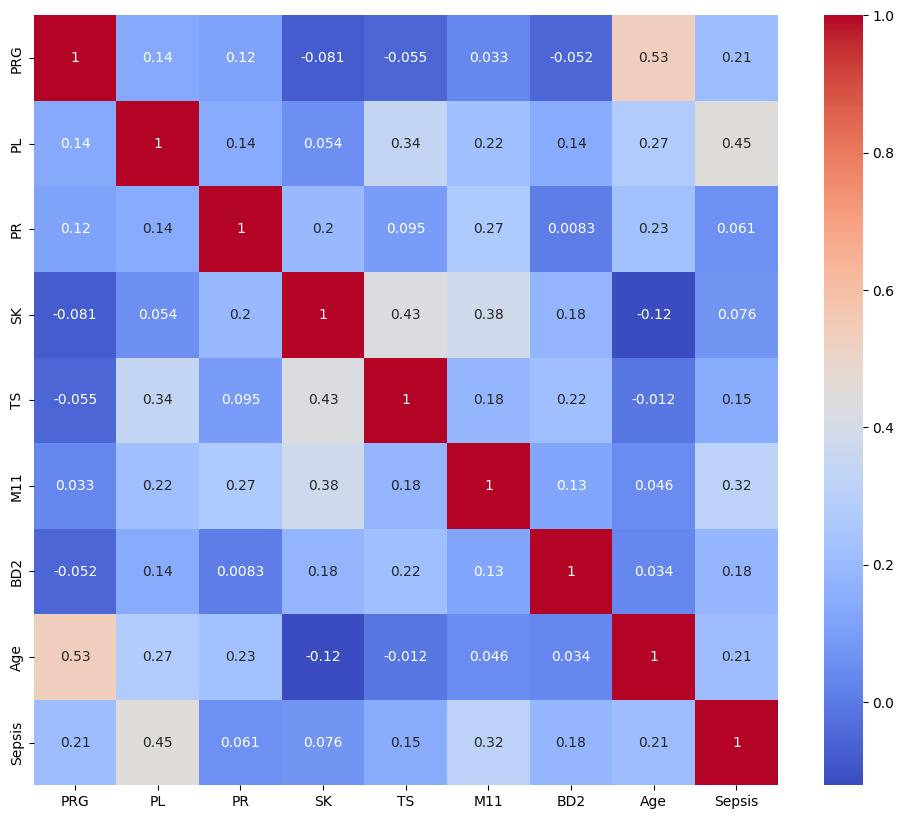

In [23]:
plt.figure(figsize=(12,10))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')

### Observation
From the heat map it can be seen that there is certain degree of correlation between PRG, PL, TS, M11, BD2 and Age with sepsis

### Data Preparation for Machine Learning

In [24]:
#  Handle Class Imbalance in target variable(sepsis)
data['Sepsis'].value_counts()

Sepsis
0    391
1    208
Name: count, dtype: int64

Note that the data is unbalanced, whereby the non-sepsis outcome is approximately double the sepsis outcome

In [25]:

# Separate majority and minority classes
data_majority = data[data.Sepsis==0]
data_minority = data[data.Sepsis==1]

# Upsample minority class
data_minority_upsampled = resample(data_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=391,    # to match majority class
                                 random_state=123) # reproducible results
 
data_upsampled = pd.concat([data_majority, data_minority_upsampled])
 
# Display new class counts
data_upsampled.Sepsis.value_counts()

Sepsis
0    391
1    391
Name: count, dtype: int64

In [ ]:
# Import necessary libraries
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Assuming you already have the 'data_upsampled' DataFrame

# Split the data
X = data_upsampled.drop('Sepsis', axis=1)
y = data_upsampled.Sepsis
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Length of X_train: " + str(len(X_train)))
print("Length of X_test: " + str(len(X_test)))

# Create a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), X_train.columns),
        ('log_transformer', FunctionTransformer(np.log1p), X_train.columns),
    ]
)

# Create a Random Forest Classifier (replace this with your preferred classifier)
rf_classifier = RandomForestClassifier()

# Create a pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf_classifier', rf_classifier),
])

# Fit the pipeline
try:
    # Before fitting the pipeline, print the transformed data for debugging
    transformed_data = rf_pipeline.named_steps['preprocessor'].transform(X_train)
    print("Transformed Data Shape:", transformed_data.shape)
    print("NaN or Infinite Values:", np.isnan(transformed_data).any() or np.isinf(transformed_data).any())
    
    print("Before fitting the pipeline")
    rf_pipeline.fit(X_train, y_train)
    print("After fitting the pipeline")
    
    # Predictions
    rf_pred = rf_pipeline.predict(X_test)

    # Evaluate the model
    print("\nRandom Forest Classifier Report:")
    print(classification_report(y_test, rf_pred))

except Exception as e:
    print("Error:", e)
    # Add more specific error handling or print traceback if needed


: 

In [ ]:
xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  Index(['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age'], dtype='object')),
                                                 ('log_transformer',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  Index(['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age'], dtype='object'))])),
                ('xgb_classifier',
                 XGBClassifier(base_score=None, booster=No...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [ ]:
joblib.dump(xgb_pipeline, 'pipeline.joblib')
joblib.dump(encoder, 'encoder.joblib')

['encoder.joblib']